In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.12.0


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Pre-Processing

In [2]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['NonDemented', 'MildDemented', 'ModerateDemented', 'VeryMildDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'MildDemented',
            'ModerateDemented',
            'NonDemented',
            'VeryMildDemented']

IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
              data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, 
                                             batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [5]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [6]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 128, 128, 3) (6400, 4)


In [7]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 128, 128, 3) (12800, 4)


In [8]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, 
                                    train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, 
                                    train_labels, test_size = 0.2, random_state=42)

In [9]:
test_data.shape

(2560, 128, 128, 3)

In [19]:
from tensorflow import keras
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [128,128,3], padding='same'),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

#keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
#keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
#keras.layers.BatchNormalization(),
#keras.layers.MaxPool2D(),
#keras.layers.Dropout(0.2),

#keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
#keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
#keras.layers.BatchNormalization(),
#keras.layers.MaxPool2D(),
keras.layers.Dropout(0.6),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model,  
           show_shapes=True, show_layer_names=True)
plt.savefig("Model.png")

<Figure size 640x480 with 0 Axes>

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks = [early_stopping, reduce_lr]

In [22]:
#Defining other parameters for the CNN model

# model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc')]

    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS,)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 separable_conv2d_6 (Separab  (None, 32, 32, 64)       2400      
 leConv2D)                                                       
                                                      

# Training 

In [23]:
history = model.fit(train_data, train_labels, 
                    validation_data=(val_data, val_labels),
                    epochs=100,verbose=1)

Epoch 1/100
256/256 [==============================] - 105s 398ms/step - loss: 1.5767 - acc: 0.3455 - val_loss: 1.5353 - val_acc: 0.2607
Epoch 2/100
256/256 [==============================] - 101s 393ms/step - loss: 1.0235 - acc: 0.5405 - val_loss: 0.9897 - val_acc: 0.5557
Epoch 3/100
256/256 [==============================] - 101s 393ms/step - loss: 0.8369 - acc: 0.6144 - val_loss: 0.6803 - val_acc: 0.6904
Epoch 4/100
256/256 [==============================] - 100s 391ms/step - loss: 0.7599 - acc: 0.6426 - val_loss: 0.6161 - val_acc: 0.6943
Epoch 5/100
256/256 [==============================] - 100s 393ms/step - loss: 0.6927 - acc: 0.6843 - val_loss: 0.5771 - val_acc: 0.7363
Epoch 6/100
256/256 [==============================] - 100s 391ms/step - loss: 0.6611 - acc: 0.6968 - val_loss: 0.7275 - val_acc: 0.6465
Epoch 7/100
256/256 [==============================] - 102s 397ms/step - loss: 0.6315 - acc: 0.7142 - val_loss: 0.4999 - val_acc: 0.7827
Epoch 8/100
256/256 [====================

# Evaluation

In [28]:
cnn_df = pd.DataFrame(history.history)

In [29]:
cnn_df.to_csv("Alz-cnn.csv")

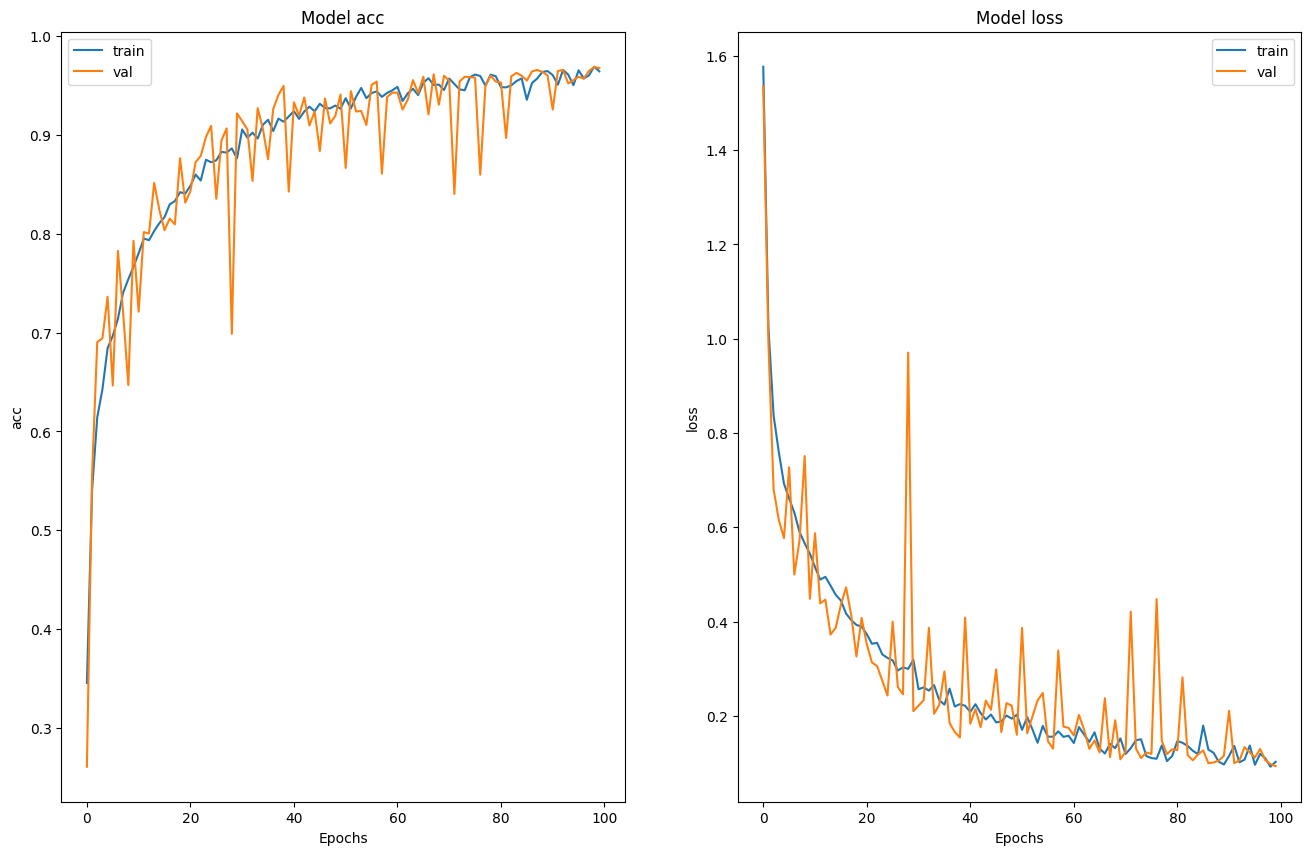

In [30]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 2, figsize = (16, 10))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [31]:
#Evaluating the model on the data

train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print((test_scores))

80/80 [==============================] - 8s 94ms/step - loss: 0.0871 - acc: 0.9645
Training Accuracy: 100.00%
Validation Accuracy: 96.78%
Testing Accuracy: 96.45%
[0.08706296980381012, 0.9644531011581421]


In [32]:
#Predicting the test data

pred_labels = model.predict(test_data)
pred_labels

80/80 [==============================] - 7s 87ms/step


array([[3.0590892e-03, 2.9276218e-06, 5.9896056e-03, 9.9094838e-01],
       [1.2003772e-09, 9.9999088e-01, 8.7672706e-06, 1.9981530e-07],
       [5.6404715e-05, 1.3999791e-06, 9.8967785e-01, 1.0264371e-02],
       ...,
       [2.8716485e-10, 9.9999970e-01, 2.0068600e-07, 1.0329617e-08],
       [1.7231391e-03, 1.7828468e-06, 6.9002450e-01, 3.0825052e-01],
       [9.9798089e-01, 8.7033104e-06, 5.3457101e-05, 1.9570631e-03]],
      dtype=float32)

In [33]:
#Print the classification report of the tested data

def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99       639
ModerateDemented       1.00      1.00      1.00       635
     NonDemented       0.95      0.93      0.94       662
VeryMildDemented       0.93      0.94      0.93       624

       micro avg       0.96      0.96      0.96      2560
       macro avg       0.96      0.96      0.96      2560
    weighted avg       0.96      0.96      0.96      2560
     samples avg       0.96      0.96      0.96      2560



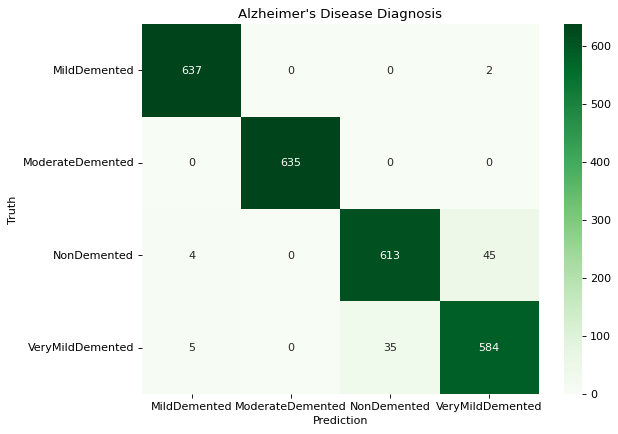

In [34]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [35]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the test image
image_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented/moderateDem10.jpg'
img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension


In [36]:
predictions = model.predict(img_array)
predictions

1/1 [==============================] - 0s 213ms/step


array([[2.6334490e-07, 9.9963772e-01, 1.2237833e-04, 2.3965268e-04]],
      dtype=float32)

In [37]:
class_index = np.argmax(predictions)
predicted_class = CLASSES[class_index]
print(f"The image belongs to class: {predicted_class}")


The image belongs to class: ModerateDemented


In [42]:
tf.keras.models.save_model(model,'modeldep_acc96.hdf5')
model.save('model1_acc96_tf.h5') 
model.save('model1_acc96_kera.h5')
# Save the entire model (architecture and weights)